<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Обзор данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Подготовка-признаков" data-toc-modified-id="Подготовка-признаков-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка признаков</a></span></li><li><span><a href="#Построение-моделей" data-toc-modified-id="Построение-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Построение моделей</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>LGBMRegressor</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li></ul></li><li><span><a href="#Выводы:" data-toc-modified-id="Выводы:-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы:</a></span></li></ul></div>

# Прогнозирование количества заказов такси

Компании, предоставляющей услуги такси, требуется модель предсказывающая количество заказов такси на следующий час. Это позволит привлекать нужное количество водителей в разные периоды спроса. В нашем распоряжении исторические данные о заказах такси в аэропортах. Необходимо построить модель для такого предсказания.
Значение метрики RMSE на тестовой выборке должно быть не больше 48.

Исследования пройдет в 5 этапов:
- обзор данных;
- анализ данных;
- подготовка данных для моделей;
- построение и выбор ниалучшей модели;
- выводы.

## Обзор данных

Импортируем библиотеки:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

from lightgbm import LGBMRegressor

SEED = 42

Считаем датасет:

In [2]:
try:
    df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
except Exception:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
def total_view(df: pd.DataFrame, n_rows=5, seed=None):
    '''Возвращает первые, случайные и последние строки таблицы (по умолчанию по 5 строк)'''
    return display(pd.concat([
                              df.head(n_rows),
                              df.sample(n_rows, random_state=seed),
                              df.tail(n_rows)
                             ]))

total_view(df)
display(df.describe().T)
df.info()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-08-05 18:40:00,8
2018-03-19 09:50:00,10
2018-07-13 14:10:00,19
2018-05-26 18:50:00,10


,count,mean,std,min,25%,50%,75%,max
num_orders,26496.0,14.070463,9.21133,0.0,8.0,13.0,19.0,119.0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
df.index.is_monotonic

True

**Выводы:**
- в таблице 2 колонки и 26496 записей. Пропущенные значения в колонке `num_orders` отсутствуют;
- данные предоставлены за период с марта по август 2018 года и расположены в хронологическом порядке;
- каждая запись а таблице - это наблюдения за 10 минутный интервал, минимальное количество заказов 0, максимальное 119.

## Анализ данных

Выполним ресемплирование по одному часу:

In [5]:
df = df.resample('1H').sum()

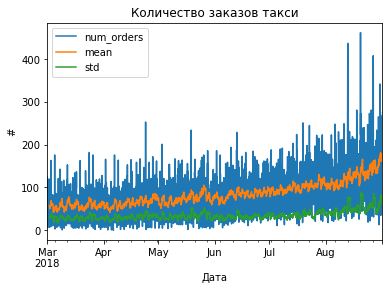

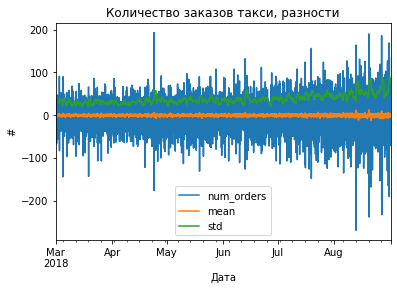

In [6]:
df_ = df.copy()
df_['mean'] = df_['num_orders'].rolling(30).mean()
df_['std'] = df_['num_orders'].rolling(30).std()

df_shift = df - df.shift()
df_shift['mean'] = df_shift['num_orders'].rolling(30).mean()
df_shift['std'] = df_shift['num_orders'].rolling(30).std()

df_.plot()
plt.title('Количество заказов такси')
plt.xlabel('Дата')
plt.ylabel('#')

df_shift.plot()
plt.title('Количество заказов такси, разности')
plt.xlabel('Дата')
plt.ylabel('#')
None

В летние месяцы, а особенно в августе отмечается повышение спроса на услуги такси в аэропортах. Также на графике заметны большие колебания значений, преимущественно в августе. 

Оценим стационарность временного ряда с помощью теста Дики-Фуллера:

In [7]:
st_test = adfuller(df, regression='ctt')
print(f'p-value: {st_test[1]}')

p-value: 4.054939787103543e-17


P-value менее 0.01, следовательно временной ряд стационарный.

Построим графики тренда и сезонности.

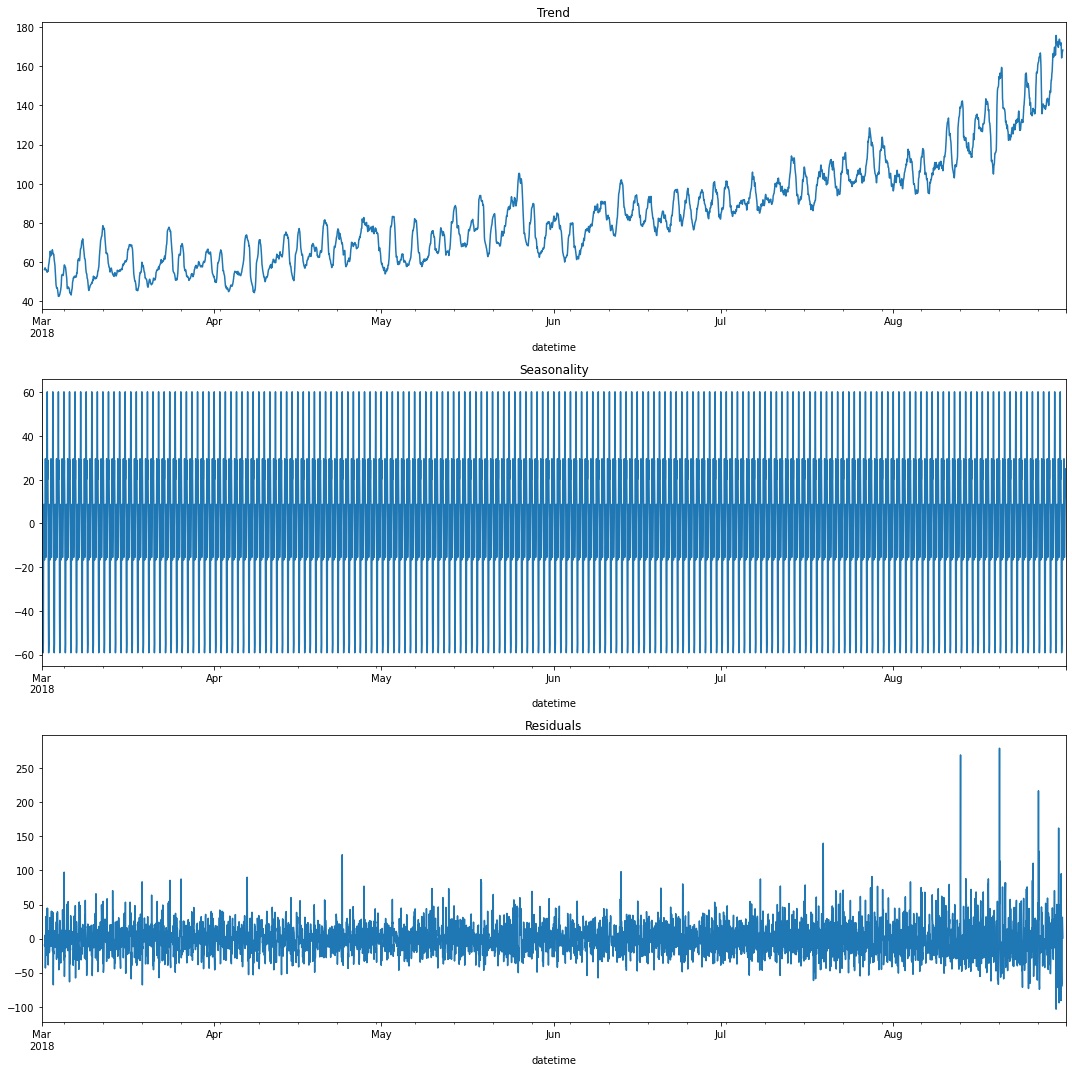

In [8]:
decomposed = seasonal_decompose(df)
plt.figure(figsize=(15, 15))

plt.subplot(311)
decomposed.trend.plot()
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot()
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot()
plt.title('Residuals')
plt.tight_layout()

На графике прослеживается тренд увеличения среднего количества заказов такси, особенно заметен рост в августе. График сезонности выглядит цикличным, значит в ряду есть закономерности. Посмотрим на график сезонной составляющей поближе:

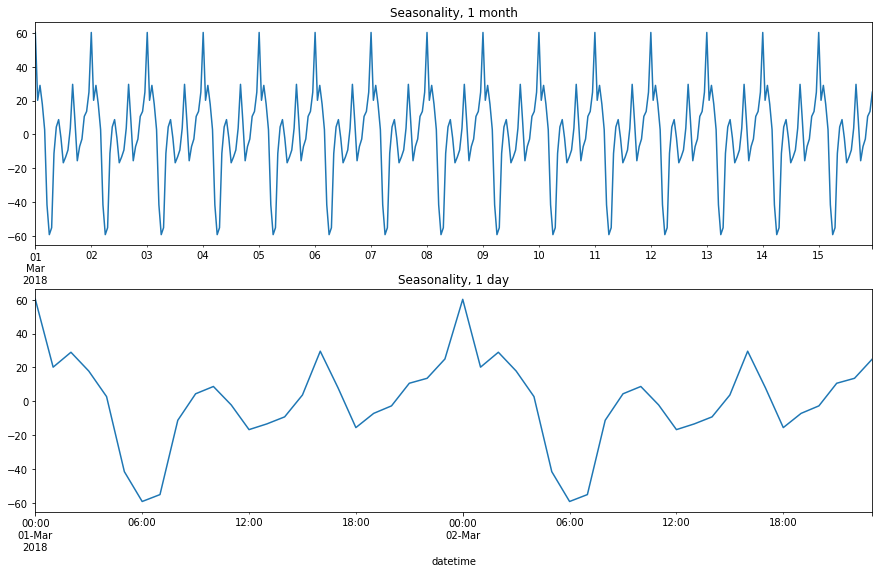

In [9]:
plt.figure(figsize=(15, 9))
plt.subplot(211)
decomposed.seasonal['2018-03-01':'2018-03-15'].plot()
plt.title('Seasonality, 1 month')

plt.subplot(212)
decomposed.seasonal['2018-03-01':'2018-03-02'].plot()
plt.title('Seasonality, 1 day')
None

Здесь прослеживается суточная цикличность - уменьшение количества заказов после полуночи и до 6 часов утра, затем рост заказов к 9-10, 16-17 часам, пик к полуночи и небольшие спады между ними.

**Выводы:**
- имеющиеся данные предоставлены за один неполный год. Без аналогичных данных за другие годы невозмжно оценить тренды и сезонность;
- по тесту Дики-Фуллера временной ряд стационарный;
- в августе отмечается заметное повышение спроса на такси в аэропортах;
- прослеживается суточная цикличность - наибольшее количество заказов такси происходит около полуночи, наименьшее около 6 утра.

## Подготовка признаков

Напишем функцию для создания признаков отстающих значений и скользящего среднего:

In [10]:
def new_features(df, lag_size, rolling_size):
    '''Создает календарные признаки, признаки с отстающими значениями от 1 до lag_size и
    скользящее среднее, рассчитанное по количеству записей rolling_size, не включая текущую запись.
    '''
    data = df.copy()
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    data['rolling_mean'] = data['num_orders'].rolling(rolling_size, closed='left').mean()
    for lag in range(1, lag_size + 1):
        data['lag_%s' % lag] = data['num_orders'].shift(lag)
    data = data.dropna()
    return data

## Построение моделей

### LinearRegression

In [11]:
best_rmse_val = 100
best_rmse_test = 100
best_lag = 0
best_roll = 0
for lag in range(1, 26):
    for roll in range(1, 15):
        data = new_features(df, lag, roll)
        x_train, x_test_, y_train, y_test_ = train_test_split(data.drop('num_orders', axis=1),
                                                              data['num_orders'],
                                                              test_size=0.2,
                                                              shuffle=False)
        x_val, x_test, y_val, y_test = train_test_split(x_test_,
                                                        y_test_,
                                                        test_size=0.5,
                                                        shuffle=False)
        
        model = LinearRegression()
        model.fit(x_train, y_train)
        preds_val = model.predict(x_val)
        preds_test = model.predict(x_test)
        rmse_val = mean_squared_error(y_val, preds_val, squared=False)
        rmse_test = mean_squared_error(y_test, preds_test, squared=False)
        if rmse_val < best_rmse_val:
            best_rmse_val = rmse_val
            best_rmse_test = rmse_test
            best_lag = lag
            best_roll = roll
print(f'RMSE: {round(best_rmse_val, 2)}',
      f'RMSE test: {round(best_rmse_test, 2)}',
      f'lag: {best_lag}',
      f'roll: {best_roll}',
      sep='\n')

RMSE: 34.37
RMSE test: 45.66
lag: 24
roll: 3


RMSE линейной регрессии на тестовой выборке составила примерно 46 поездок. В цикле подобрано нужное количество признаков с отстающим значением (24) и размер скользящего среднего (3).

### LGBMRegressor

In [12]:
data = new_features(df, 24, 3)

x_train, x_test, y_train, y_test = train_test_split(data.drop('num_orders', axis=1),
                                                            data['num_orders'],
                                                            test_size=0.1,
                                                            shuffle=False)

model = LGBMRegressor(random_state=SEED, metric='rmse')

param_grid = {'max_depth': [4, 5, 6],
              'n_estimators': [90, 100, 110, 120],
              'learning_rate': [0.1, 0.2, 0.3]
              }

cv = TimeSeriesSplit(8)
grid = GridSearchCV(model, param_grid=param_grid, cv=cv, scoring='neg_root_mean_squared_error')
grid.fit(x_train, y_train)

preds_lgbm = grid.predict(x_test)
rmse_lgbm = mean_squared_error(y_test, preds_lgbm, squared=False)

print(f'RMSE: {-1 * grid.best_score_}',
      f'RMSE test: {rmse_lgbm}',
      'Наилучшие параметры:',
      f'max_depth: {grid.best_params_["max_depth"]}',
      f'n_estimators: {grid.best_params_["n_estimators"]}',
      f'learning_rate: {grid.best_params_["learning_rate"]}',
      sep='\n')

RMSE: 24.14226214571493
RMSE test: 40.473946665822936
Наилучшие параметры:
max_depth: 5
n_estimators: 110
learning_rate: 0.1


Модель LGBMRegressor с параметрами max_depth 5,  n_estimators 110 и learning_rate 0.1 достигла RMSE 40.47 на тестовой выборке.

### RandomForestRegressor

In [13]:
model = RandomForestRegressor(random_state=SEED)
param_grid = {'max_depth': [6, 7, 8, 9],
              'n_estimators': [100, 110, 130]
              }
grid = GridSearchCV(model, param_grid=param_grid, cv=cv, scoring='neg_root_mean_squared_error')
grid.fit(x_train, y_train)

preds_rf = grid.predict(x_test)
rmse_rf = mean_squared_error(y_test, preds_rf, squared=False)

print(f'RMSE: {-1 * grid.best_score_}',
      f'RMSE test: {rmse_rf}',
      'Наилучшие параметры:',
      f'max_depth: {grid.best_params_["max_depth"]}',
      f'n_estimators: {grid.best_params_["n_estimators"]}',
      sep='\n')

RMSE: 24.721721906848018
RMSE test: 43.839493298284225
Наилучшие параметры:
max_depth: 9
n_estimators: 110


Модель случайного леса с параметрами max_depth 9 и n_estimators 110 достигла RMSE примерно в 44 поездки.

Построим график предсказанных и истинных значений на промежутке с 2018-08-13 по 2018-08-15:

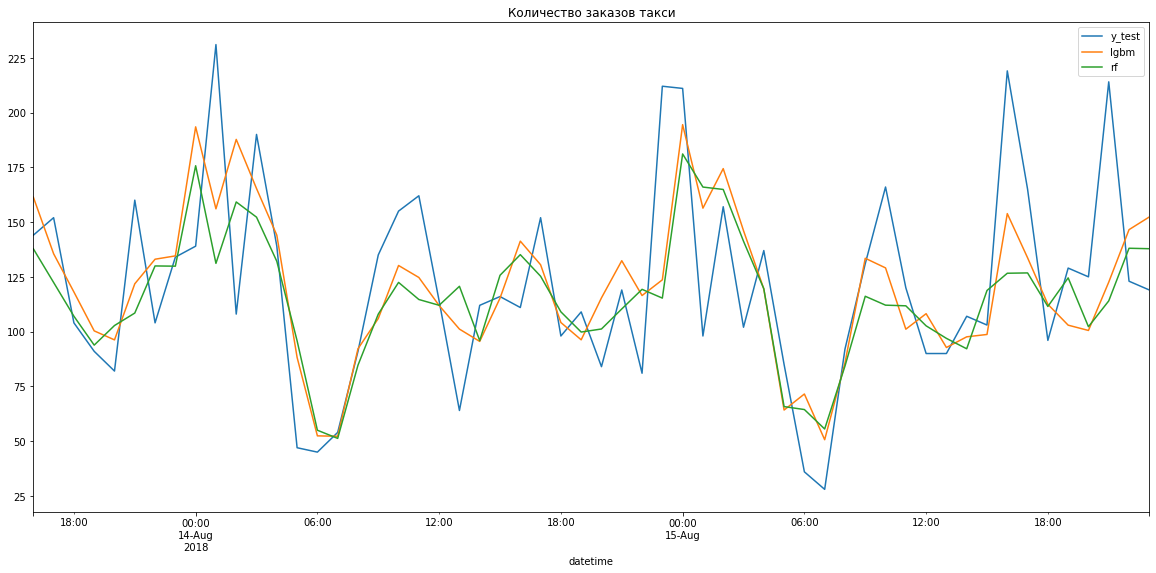

In [14]:
plt.figure(figsize=(20, 9))
y_test['2018-08-13':'2018-08-15'].plot(ax=plt.gca())
pd.DataFrame(preds_lgbm, index=y_test.index)['2018-08-13':'2018-08-15'].plot(ax=plt.gca())
pd.DataFrame(preds_rf, index=y_test.index)['2018-08-13':'2018-08-15'].plot(ax=plt.gca())
plt.legend(['y_test', 'lgbm', 'rf'])
plt.title('Количество заказов такси')
None

Предсказания модели LGBMRegressor лучше аппроксимированы, по сравнению с предсказаниями модели случайного леса - пики и впадины графика lgbm больше похожи на истинные значения, график случайного леса более сглаженный.

**Выводы:**
- с помощью линейной регрессии был подобран оптимальный состав признаков с отстающим значением до 24 и размером скользящего среднего 3;
- лучший RMSE (40.47) удалось достичь с помощью LGBMRegressor с параметрами max_depth 5, n_estimators 110 и learning_rate 0.1.

## Выводы:
- в датасете содержится информация о количестве заказов такси с марта по август 2018 года;
- временной ряд не стационарный, так как с течением времени у него увеличивается среднее значение и дисперсия;
- оптимальный состав признаков - с отстающим значением до 24 и размером скользящего среднего 6;
- наилучшую RMSE удалось достичь с помощью модели LGBMRegressor с параметрами max_depth 5, n_estimators 110 и learning_rate 0.1. RMSE модели составила примерно 41 поездку.